In [1]:
%load_ext autoreload
%autoreload 2

### load libraries

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams['font.size'] = 13
plt.rcParams['figure.dpi'] = 300

### read data

In [3]:
# read data
with open("../data/data.csv") as f:
    next(f)
    data = f.readlines()
data = [d.strip().split(",") for d in data] 

In [4]:
smiles = [str(dt[0]) for dt in data]
redoxp = [float(dt[1]) for dt in data]
print(len(smiles), len(redoxp))

302 302


In [5]:
data = pd.DataFrame({"smiles": smiles, "redox_potential": redoxp})
data.head()

,smiles,redox_potential
0,NC=O,6.12
1,CN(C)C=O,4.93
2,CN(C)C(C)=O,4.74
3,CNC(C)=O,5.32
4,CC(N)=O,6.00


In [6]:
from rdkit import Chem

def canonical_smiles(smiles):
    return Chem.MolToSmiles(Chem.MolFromSmiles(smiles))


data["canonical_smiles"] = data["smiles"].apply(canonical_smiles)
data.head()

,smiles,redox_potential,canonical_smiles
0,NC=O,6.12,NC=O
1,CN(C)C=O,4.93,CN(C)C=O
2,CN(C)C(C)=O,4.74,CC(=O)N(C)C
3,CNC(C)=O,5.32,CNC(C)=O
4,CC(N)=O,6.00,CC(N)=O


In [7]:
data = data[['smiles', 'canonical_smiles', 'redox_potential']]
print(data.shape)
data.head()

(302, 3)


,smiles,canonical_smiles,redox_potential
0,NC=O,NC=O,6.12
1,CN(C)C=O,CN(C)C=O,4.93
2,CN(C)C(C)=O,CC(=O)N(C)C,4.74
3,CNC(C)=O,CNC(C)=O,5.32
4,CC(N)=O,CC(N)=O,6.00


[Text(0.5, 0, 'Redox potential')]

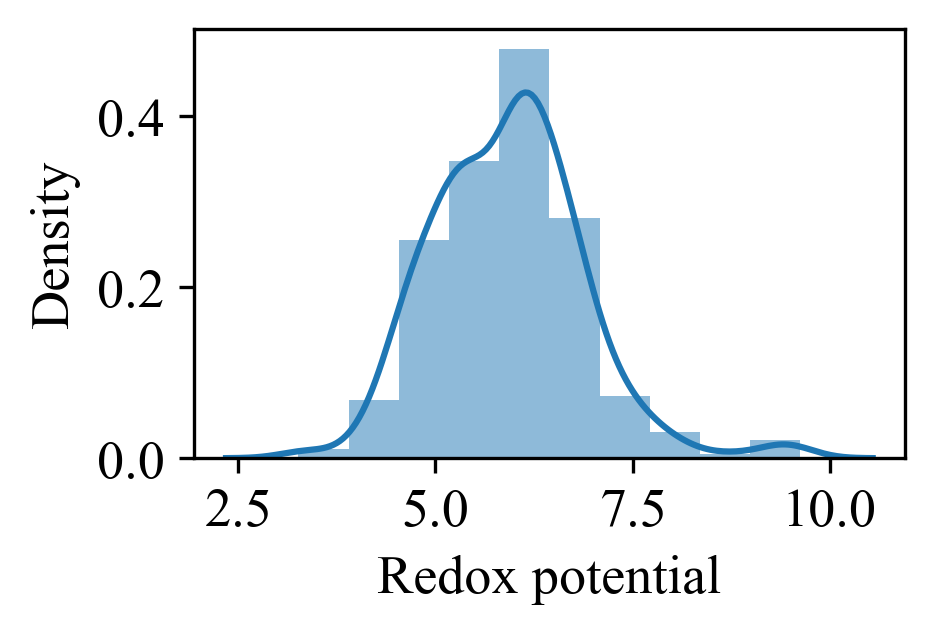

In [8]:
fig, ax = plt.subplots(
    constrained_layout=True, ncols=1, figsize=(3, 2)
)
_, _, hist = ax.hist(redoxp, density=True, alpha=0.5)

sns.kdeplot(redoxp, ax=ax, color=hist[0].get_facecolor())
ax.set(xlabel="Redox potential")

In [9]:
from tqdm import tqdm  # add a progress bar
from rdkit import Chem
from rdkit.Chem import Draw, rdCoordGen
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG

IPythonConsole.ipython_useSVG = True

In [10]:
def make_molecules_from_smiles(smiles):
    molecules = []
    for smilei in tqdm(smiles):
        mol = Chem.MolFromSmiles(smilei)
        rdCoordGen.AddCoords(mol)
        molecules.append(mol)
    return molecules

In [11]:
molecules = make_molecules_from_smiles(smiles)

100%|██████████| 302/302 [00:00<00:00, 4136.99it/s]


Let us show the molecules with the highest and lowest redox potential: 

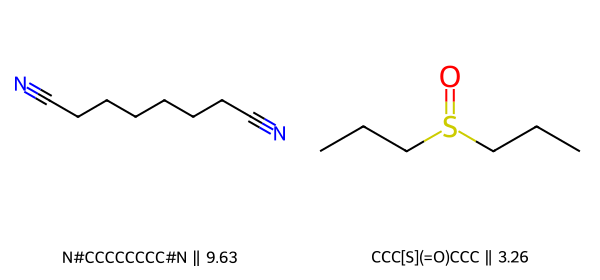

In [12]:
mols = []
legends = []
idx_max, idx_min = np.argmax(redoxp), np.argmin(redoxp)

for i in (idx_max, idx_min):
    mols.append(molecules[i])
    legends.append(f"{smiles[i]} || {redoxp[i]:.3g}")

drawing = Draw.rdMolDraw2D.MolDraw2DSVG(600, 280, 300, 280)
options = drawing.drawOptions()
options.drawMolsSameScale = False
options.fixedBondLength = 50
options.legendFraction = 0.25
drawing.DrawMolecules(mols, legends=legends)
drawing.FinishDrawing()
SVG(drawing.GetDrawingText())


save and split data

In [13]:
data = data[['canonical_smiles', 'redox_potential']]
data.columns = ['smiles', 'label']

In [14]:
data.to_csv("../data/data_cleaned.csv", index=False)

In [15]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=42)


[Text(0.5, 0, 'Redox potential')]

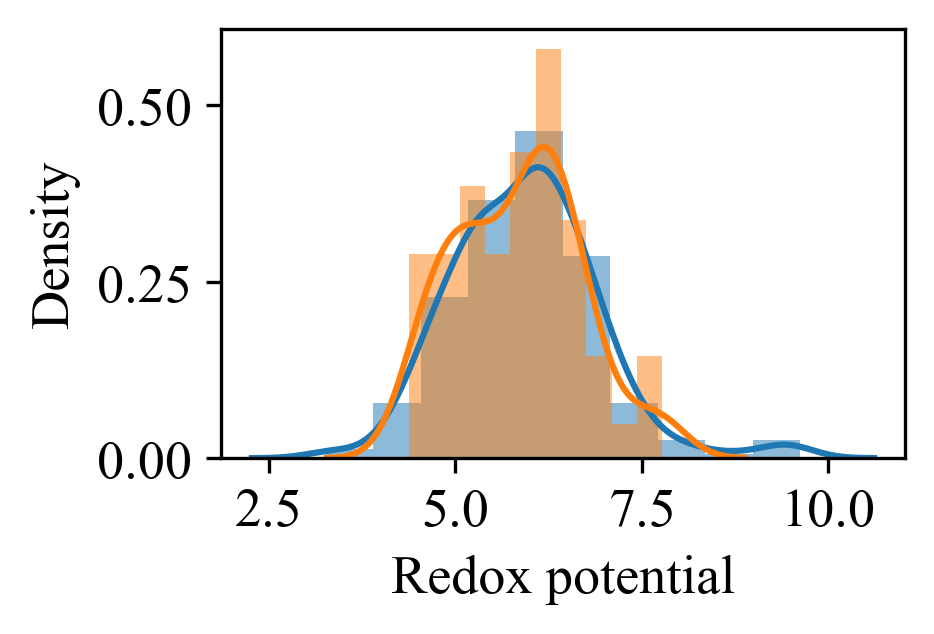

In [24]:
fig1, ax1 = plt.subplots(
    constrained_layout=True, ncols=1, figsize=(3, 2)
)
_, _, hist1 = ax1.hist(train.label, density=True, alpha=0.5)
_, _, hist2 = ax1.hist(test.label, density=True, alpha=0.5)

sns.kdeplot(train.label, ax=ax1, color=hist1[0].get_facecolor())
sns.kdeplot(test.label, ax=ax1, color=hist2[0].get_facecolor())
ax1.set(xlabel="Redox potential")

In [27]:
train.to_csv("../data/train_data_cleaned.csv", index=False)
test.to_csv("../data/test_data_cleaned.csv", index=False)